<a id='top'></a>
# NIRSpec IFU Pipeline Processing ERO 02732 NGC 7319 AGN -- Point Source
<hr style="border:3px solid black">

## Table of Contents

* [1. Introduction](#intro)
* [2. Import Library](#imports)
* [3. Convenience Functions](#func)
* [4. Directory Set-Up](#dir_setup)
* [5. Download the data](#data)
* [6. Stage 1](#stage1)
* [7. Stage 2](#stage2)
* [8. Stage 3](#stage3)
    * [8.1 New Outlier Detection Algorithm](#outlier_detection_new)
    * [8.2 Extract 1-D Step: Modified Reference File](#extract_1d)
* [About This Notebook](#about)



## 1. Introduction <a id='intro'></a>
<hr style="border:1px solid gray">

End-to-end calibration of JWST data is divided into 3 main stages of processing. This notebook explores how to run the JWST calibration pipeline stages 1-3 for NIRSpec IFU spectroscopic data.
   <figure>
       <img src='./NGC_7319_AGN.png' title="Figure 1: NGC 7319 AGN" alt="NGC_7319_AGN" class="bg-primary" align="right" style="width: 400px; height: 350px;"/>
   </figure>

>* **`STAGE 1`** ([calwebb_detector1](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1)): consists of detector-level corrections, performed on a group-by-group basis, followed by ramp fitting.
    * **Input**: Raw exposure (`uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
    * **Output**: Corrected countrate (slope) image (`rate.fits`) 
>* **`STAGE 2`** ([calwebb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)): consists of additional instrument-level and observing mode corrections and calibrations.
    * **Input**: A single corrected countrate (slope) image (`rate.fits`) or an ASN file listing multiple inputs.
    * **Output**: A fully calibrated unrectified exposure (`cal.fits`). For NIRSpec IFU data, the `cube_build` step returns a 3-D IFU spectroscopic cube (`s3d.fits`). The `extract_1d` step  returns 1-D extracted spectral data products (`x1d.fits`)
>* **`STAGE 3`** ([calwebb_spec3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html#calwebb-spec3)): consists of additional corrections (e.g. `outlier_detection`) and routines for combining calibrated data from multiple exposures (e.g. dither/nod pattern) into a single combined 2-D or 3-D spectral product and a combined 1-D spectrum. 
    * **Input**: An ASN file that lists multiple calibrated exposures (`cal.fits`).
    * **Output**: For NIRSpec IFU data, a resampled and combined 3-D IFU cube (`s3d.fits`) and a 1-D extracted spectrum (`x1d.fits`)

Here, we will focus on the mechanics of processing "real" example data [(NGC 7319 AGN)](#NGC_7319_AGN) from Early Release Science (ERS) Proposal ID 2732, including how to use associations for multi-exposure combination, how to interact and work with data models for each product, and in this particular case, how to manually process the compact region at the center of the AGN as a point source.

Most processing runs shown here use the default reference files from the Calibration Reference Data System (CRDS), with one exception at the end to show an example of how to modify/override. Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if using a subsequent version. There are also a few known issues with some of the pipeline steps in this build that we expect to be fixed in the near future. Until then, at various steps, we provide users with the current processing recommendations when running the pipeline manually.

## 2. Import Library <a id='imports'></a>
<hr style="border:1px solid gray">

In [2]:
# Import Library
# --------------------------------------Set CRDS environment variables----------------------------------------------

import os
os.environ['CRDS_CONTEXT'] = 'jwst_1089.pmap'
os.environ['CRDS_PATH'] = os.environ['HOME']+'/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
print(f'CRDS cache location: {os.environ["CRDS_PATH"]}')

# --------------------------------------JWST Calibration Pipeline Imports-------------------------------------------
import jwst
import crds
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step

print("JWST Calibration Pipeline Version={}".format(jwst.__version__))
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

# ----------------------------------------------General Imports-----------------------------------------------------

import numpy as np
import warnings
warnings.filterwarnings('ignore') # Set to 'default' to turn warnings back on

# --------------------------------------------File Operation Imports------------------------------------------------
import glob
import os
import asdf
import json
from shutil import copy

# --------------------------------------------Astropy/Astroquery Imports--------------------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch
from astroquery.mast import Observations

# ------------------------------------------------Plotting Imports--------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as grd
from matplotlib.patches import Circle
from matplotlib import cm

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline
# Use this version (outside of Jupyter Lab) if you want interactive plots
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 18})

CRDS cache location: /Users/hkaratay/crds_cache
JWST Calibration Pipeline Version=1.12.3
Current Operational CRDS Context = jwst_1137.pmap


## 3. Convenience Functions <a id='func'></a>
<hr style="border:1px solid gray">

In [3]:
def show_image(data_2d, vmin, vmax, xsize=15, ysize=15, title=None, zoom_in=None, aspect=1, scale='log', units='DN/s', cmap='jet'):
    """
    Function to generate a 2-D, log-scaled image of the data
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        2-D image to be displayed
    vmin : float
        Minimum signal value to use for scaling
    vmax : float
        Maximum signal value to use for scaling
    xsize, ysize: int
        Figure Size
    title : str
        String to use for the plot title
    zoom_in: list 
        Zoomed in Region of interest [xstart,xstop,ystart,ystop]
    aspect: int
        Aspect ratio of the axes
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear' or 'Asinh'
    units : str
        Units of the data. Used for the annotation in the color bar. Defualt is DN/s for countrate images
    cmap: str
        Color Map for plot
    """
    # -----------------------------------------Scaling Information----------------------------------------
    
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    elif scale == 'Asinh':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=AsinhStretch())
    
    # --------------------------------------------Set Up Figure-------------------------------------------

    fig = plt.figure(figsize=(xsize, ysize))
    ax = fig.add_subplot(1, 1, 1)
    
    im = ax.imshow(data_2d, origin='lower', norm=norm, aspect=aspect, cmap=cmap)

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    if title:
        plt.title(title)
    
    # Zoom in on a portion of the image? 
    if zoom_in:
        # inset axis 
        axins = ax.inset_axes([0.5, 0.6, 0.5, 0.3])
        
        axins.imshow(data_2d, origin="lower", norm=norm, aspect=aspect, cmap=cmap)
        
        # subregion of the original image
        axins.set_xlim(zoom_in[0], zoom_in[1])
        axins.set_ylim(zoom_in[2], zoom_in[3])
        axins.set_xticklabels([])
        axins.set_yticklabels([])
        ax.indicate_inset_zoom(axins, color="black", edgecolor="black", linewidth=3)

In [3]:
def show_ifu_cubeslices(s3d_file_list, wavelength_slices=[], spaxel_locs=[], y_scale=None, cmap='jet', vmin_vmax=[[[0, 15e1]]], save_figure=False, title=None, title_font=30):
    """
    Function to that takes a 3-D IFU data cube and generates: 
    
    > 2-D cube slices based on wavelength (microns)
    > Associated 1-D spectrum for a designated spaxel (spatial pixel) in the data cube
    > Corresponding 3-D weight image giving the relative weights of the output spaxels
    
    Note: This function can accommodate multiple detectors plotted side-by-side. 
    The general format would follow [[detector 1 info], [detector 2 info]].

    Parameters
    ----------
    s3d_file_list: list of str
        3-D IFU data cube fits file list 
    wavelength_slices: tuple
        List of wavelength values (microns) at which to create 2-D slices. 
    spaxel_locs: tuple
        List of spaxel locations in which to plot the associated 1-D spectrum. (One spaxel location per slice)
    y_scale: tuple
        Y-axis limits for the associated 1-D spectrum of the spaxel. Default is to use the ymin and ymax of the data. 
    cmap: str
        Color Map 
    vmin_vmax: tuple
        Minimum & Maximum signal value to use for scaling (e.g., [[[vmin,vmax],[vmin,vmax]], [[vmin,vmax], [vmin,vmax]]])
    title: str
        Figure Title. Default is None. 
    title_font:int
        Title Font Size
    save_figure: bool
        Save figure?         
    """
    
    # ---------------------------------------------- Set-up Figure -------------------------------------------------

    # Plot Slices From the Cube
    fig, axs = plt.subplots(3, np.array(wavelength_slices).size, figsize=(8*np.array(wavelength_slices).size, 18))
    gs = grd.GridSpec(3, np.array(wavelength_slices).size, height_ratios=[1]*3, width_ratios=[1]*np.array(wavelength_slices).size, hspace=0.4, wspace=0.7)

    total_num_plots = 3*np.array(wavelength_slices).size
    
    plot_count = 0
    # ---------------------------------------------Open Files------------------------------------------------------
    
    for s3d_file in s3d_file_list:
        
        root = s3d_file[:-9] # Root file name 

        s3d = fits.open(s3d_file) # 3-D IFU data cube fits file 
        x1d3 = datamodels.open(root+'_x1d.fits') # 1-D Extracted Spectrum            
    
        # --------------------------------Wavelength & Surface Brightness/Flux Arrays------------------------------
    
        x1d3wave = x1d3.spec[0].spec_table.WAVELENGTH
            
        # --------------------------------------Data & Header Information------------------------------------------

        # SCI Extension: [Type:ImageHDU  Cards:92   Dimensions:(57, 61, 973)   Format:float32]
        cube = s3d[1].data # Science data
        wcs = WCS(s3d[1].header) # World Coordinate System (WCS) Transformation keywords   # noqa
        wmap = s3d[4].data # 3-D weight image giving the relative weights of the output spaxels.
        cdelt1 = s3d[1].header['CDELT1']*3600. # Axis 1 coordinate increment at reference point  # noqa
        cdelt2 = s3d[1].header['CDELT2']*3600. # Axis 2 coordinate increment at reference point  # noqa
        cdelt3 = s3d[1].header['CDELT3'] # Axis 3 coordinate increment at reference point 
        crval3 = s3d[1].header['CRVAL3'] # Third axis value at the reference pixel  

        # Wavelength range of the grating/filter combination
        wavstart = s3d[1].header['WAVSTART']
        wavend = s3d[1].header['WAVEND']
        s3d.close()
    
        # ---------------------------------------------------Plots-------------------------------------------------
        
        cmap_custom = cm.colors.LinearSegmentedColormap.from_list("", ["darkred", "darkturquoise", "blue"])
        colors = cmap_custom(np.linspace(0, 1, np.array(wavelength_slices).size))

        # To Account for if NRS1 & NRS2 are both being plotted Side-by-side
        if len(wavelength_slices) != 1:
            if 'nrs1' in s3d_file:
                wavelengths = wavelength_slices[0]
                spaxel_loc = spaxel_locs[0]
                vmin_vmax_vals = vmin_vmax[0]
                
                if y_scale:
                    y_scales = y_scale[0]

            elif 'nrs2' in s3d_file:
                wavelengths = wavelength_slices[1]
                spaxel_loc = spaxel_locs[1]
                vmin_vmax_vals = vmin_vmax[1]
                if y_scale:
                    y_scales = y_scale[1]

        else:
            wavelengths = wavelength_slices[0]
            spaxel_loc = spaxel_locs[0]
            vmin_vmax_vals = vmin_vmax[0]
            if y_scale:
                y_scales = y_scale[0]

        # Loop through each wavelength slices
        for i, wave_slice in enumerate(wavelengths):

            if float(wavstart) <= wave_slice*10**-6 <= float(wavend):
                
                # --------------------------------------------2-D Cube Slice------------------------------------------------
            
                # Min & Max Image Values & Scaling
                if len(vmin_vmax_vals) != 1:
                    vmax_val = vmin_vmax_vals[i][1]
                    vmin_val = vmin_vmax_vals[i][0]
                else:
                    vmax_val = vmin_vmax_vals[0][1]
                    vmin_val = vmin_vmax_vals[0][0]

                slicewave = wave_slice
                nslice = int((slicewave - crval3)/cdelt3) # The slice of the cube we want to plot
                ax1 = plt.subplot(gs[0+plot_count], projection=wcs, slices=('x', 'y', nslice)) # Set up the subplot space
                # ax1 = plt.subplot(3,len(wavelength_slices), 0+plot_count, projection=wcs, slices=('x', 'y', nslice)) # Set up the subplot space

                slice_mean = np.nanmean(cube[(nslice-2):(nslice+2), :, :], axis=0) # Mean of the slice looking in the range (nslice-2):(nslice+2)
                slice_norm = ImageNormalize(slice_mean, vmin=vmin_val, vmax=vmax_val, stretch=AsinhStretch()) # Normalize &stretch 
                slice_image = ax1.imshow(slice_mean, norm=slice_norm, origin='lower', aspect='auto', cmap=cmap) # Plot slice

                cb_image = fig.colorbar(slice_image, fraction=0.046, pad=0.04)
                cb_image.set_label('MJy/sr', labelpad=-1, fontsize=22)
                cb_image.ax.tick_params(labelsize=20)
                cb_image.ax.yaxis.get_offset_text().set_fontsize(20)
                
                ax1.set_xlabel('RA', fontsize=22)
                ax1.set_ylabel('DEC', labelpad=-1, fontsize=22)
                # ax1.grid(color='white', ls='solid')
                ax1.set_title('Detector {} \n Grating/Filter: {}/{} \n {} microns'.format(s3d[0].header['DETECTOR'], s3d[0].header['GRATING'], s3d[0].header['FILTER'], str(slicewave)), fontsize=25)
                ax1.tick_params(axis='both', which='major', labelsize=20)
                ax1.coords[0].set_ticklabel(rotation=13, ha='right', pad=24)

                # ------------------------------------------Spaxel 1-D Spectrum---------------------------------------------
                
                # Zoom in on a Spaxel: Spectrum
                loc = [spaxel_loc[i][0], spaxel_loc[i][1]]
                x1d3flux_loc = cube[:, loc[1], loc[0]]
                # ax2 = plt.subplot(3,len(wavelength_slices), int(total_num_plots/3)+plot_count)
                ax2 = plt.subplot(gs[int(total_num_plots/3)+plot_count])

                # Spaxel Box Highlight 
                spaxel_rect = plt.Rectangle((loc[0]-.5, loc[1]-.5), 1, 1, fill=False, color='black', linewidth=2)
                ax1.add_patch(spaxel_rect)
                
                ax2.plot(x1d3wave, x1d3flux_loc, linewidth=1, color=colors[i])
                ax2.grid(linewidth=2)
                ax2.set_xlabel('$\u03BB [\u03BC$m]', fontsize=22)
                ax2.set_ylabel("Surface Brightness \n (MJy/sr)", fontsize=22)
                ax2.set_title('Spaxel at (x, y)='+repr(loc), fontsize=25)
                ax2.tick_params(axis='both', which='major', labelsize=20)
                ax2.yaxis.get_offset_text().set_fontsize(15)
                
                # Scale Information
                if y_scale:
                    ymin, ymax = y_scales[i][0], y_scales[i][1]
                else:
                    ymin, ymax = ax2.set_ylim()
                
                ax2.set_ylim(ymin, ymax)
                ax2.xaxis.set_tick_params(labelsize=20)
                ax2.yaxis.set_tick_params(labelsize=20)
                ax2.set_aspect(0.5/ax2.get_data_ratio())
                
                # -----------------------------------------------Weight Map-------------------------------------------------
                
                # Corresponding Weight Map (wmap) for Cube Slice
                ax3 = plt.subplot(gs[int(total_num_plots)-np.array(wavelength_slices).size+plot_count], projection=wcs, slices=('x', 'y', nslice)) # Set up the subplot space
                # ax3 = plt.subplot(3, len(wavelength_slices), int(total_num_plots)-len(wavelength_slices)+plot_count, projection=wcs, slices=('x', 'y', nslice)) # Set up the subplot space
                
                slice_mean_wmap = np.nanmean(wmap[(nslice-2):(nslice+2), :, :], axis=0) # Mean of the wmap slice looking in the range (nslice-2):(nslice+2)
                slice_norm_wmap = ImageNormalize(slice_mean_wmap, stretch=AsinhStretch()) # Normalize & stretch
                slice_wmap = ax3.imshow(slice_mean_wmap, norm=slice_norm_wmap, origin='lower', aspect='auto', cmap=cmap) # Plot slice

                cb_wmap = fig.colorbar(slice_wmap, fraction=0.046, pad=0.04)
                cb_wmap.set_label('Weight', labelpad=-1, fontsize=22)
                cb_wmap.ax.tick_params(labelsize=20)
                cb_wmap.ax.yaxis.get_offset_text().set_fontsize(20)
                
                ax3.set_xlabel('RA', fontsize=22)
                ax3.set_ylabel('DEC', labelpad=-1, fontsize=22)
                # ax3.grid(color='gray', ls='solid')
                ax3.set_title(str(slicewave)+' microns: Weight Map', fontsize=25)
                ax3.tick_params(axis='both', which='major', labelsize=20)
                ax3.coords[0].set_ticklabel(rotation=13, ha='right', pad=24)

                plot_count += 1
                    
            else:
                None
    
    if title:
        fig.suptitle(title, fontsize=title_font)
        plt.subplots_adjust(top=0.8) 
    
    fig.tight_layout(rect=[0, 0, 0.98, 0.98])

    if save_figure:
        fig.savefig(root+".png", dpi=24, bbox_inches="tight")

## 4. Directory Set-Up <a id='dir_setup'></a>
<hr style="border:1px solid gray">

In [10]:
# To rerun the notebook and all the pipeline steps set runflag=True
runflag = True 

# Demo directory -- contains pre-computed products
if not runflag:
    output_dir = './nirspec_ifu_02732_demo/'

# Rerun directory
elif runflag:
    # If you want to actually re-download the data and run everything offline, 
    # then comment out this line, set runflag=True, & specify a desired local directory
    output_dir = './nirspec_ifu_02732_rerun/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

## 5. Download the Data <a id='data'></a>

<hr style="border:1px solid gray">
<div class="alert alert-block alert-info">

<b>Tip:</b> To download the data from MAST, you must input your MAST authorization token. Get your MAST Token Here: https://auth.mast.stsci.edu/token. Additionally, be sure to follow [astroquery installation procedures](https://astroquery.readthedocs.io/en/latest/index.html#) to properly run this cell. 
    
</div> 

| Target: NGC 7319 AGN |       |   |   |   |
|:-----------:|:-------:|---|---|---|
| Proposal ID | 02732 |   |   |   |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-ifu-spectroscopy)   | PRISM/CLEAR | λ: 0.6–5.3 μm (a low resolution, R ~ 100) |   |   |
|   DURATION  | 160.478 [s] | Total duration of one exposure |   |   |   |
|   READPATT  | NRSIRS2RAPID | Readout Pattern |   |   |   |
|   PATTTYPE  | CYCLING | Primary dither pattern type |   |   |
|   PATTSIZE  | LARGE | Primary dither pattern size (1.0" extent) |   |   |
|   NUMDTHPT  | 8 | Total number of points in pattern |   |   | 
|   SRCTYAPT  | UNKNOWN | Source Type selected in APT |   |   | 

> **Note:** The presence of a physical gap between detectors affects high-resolution IFU observations because the spectra are long enough to span both NIRSpec detectors. When using the grating-filter combination G140H/F070LP (or PRISM/CLEAR) the resulting spectra do not have any gaps because the spectra do not extend beyond NRS1. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-ifu-operations/nirspec-ifu-wavelength-ranges-and-gaps#NIRSpecIFUWavelengthRangesandGaps-Wavelengthgaps)

The cell below downloads the raw uncalibrated data along with the stage 2 and stage 3 products that are available in MAST. MAST products will get saved to a folder called `mast_products` within the designated output directory defined earlier in this notebook. These files have already been pre-downloaded and stored in a provided demo directory. To get the most up-to-date products set `runflag = True` and rerun this notebook. 

In [5]:
# Download data from MAST 

# Setup your account 

# NOTE:
# The data in this notebook is public and does not require a token.
# For other data sets, uncomment the following line and enter your
# token at the prompt.

# Observations.login(token=None)

sessioninfo = Observations.session_info()

# Define the general search criteria
obs = Observations.query_criteria(
        obs_collection='JWST',
        instrument_name=['NIRSPEC/IFU'],
        proposal_id='02732')

# Print the Observations returned from the general search criteria
products = Observations.get_product_list(obs)
# print(products)

# Filter the list of observations
# In this case we look for UNCAL products and ASN files to manually run pipeline stage 1-3
# We look for pre-processed MAST products for comparison: RATE (stage 1) & CAL (stage 2&3) & S3D (stage 2&3) & X1D (stage2&3)  
filtered = Observations.filter_products(products,
                                        productSubGroupDescription=["UNCAL", "ASN"],
                                        mrp_only=False)
# Print the filtered products
number_of_filtered_products = len(filtered)
for k in range(number):
    print(filtered['productFilename'][k])

# Download the filtered products
# This creates a mastDownload directory, unless you set flat=True and set a download_dir
for i in range(number_of_filtered_products):
    mast_products_dir = output_dir+'mast_products/'
    if not os.path.exists(mast_products_dir):
        os.makedirs(mast_products_dir)
    if runflag:
        Observations.download_products(filtered[i], mrp_only=False, cache=False, flat=True, download_dir=mast_products_dir) # Override any cached files and download the most up-to-date ones
    else:
        Observations.download_products(filtered[i], mrp_only=False, cache=True, flat=True, download_dir=mast_products_dir) # Find any cached files first before downloading new ones

eppn: 
ezid: anonymous
anon: True
scopes: []
session: None
token: None
jw02732-o003_20230401t123831_spec3_00001_asn.json
jw02732-o003_20230401t123831_spec2_00004_asn.json
jw02732003001_02101_00001_nrs1_uncal.fits
jw02732003001_02101_00001_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00005_asn.json
jw02732003001_02101_00002_nrs1_uncal.fits
jw02732003001_02101_00002_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00015_asn.json
jw02732003001_02101_00003_nrs1_uncal.fits
jw02732003001_02101_00003_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00007_asn.json
jw02732003001_02101_00004_nrs1_uncal.fits
jw02732003001_02101_00004_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00001_asn.json
jw02732003001_02101_00005_nrs1_uncal.fits
jw02732003001_02101_00005_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00016_asn.json
jw02732003001_02101_00006_nrs1_uncal.fits
jw02732003001_02101_00006_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00003_asn.json
jw02732003001_02101_00007

In [6]:
sessioninfo = Observations.session_info()

# Define the general search criteria
obs = Observations.query_criteria(
        obs_collection='JWST',
        instrument_name=['NIRSPEC/IFU'],
        proposal_id='02732')

# Print the Observations returned from the general search criteria
products = Observations.get_product_list(obs)
print(products)
filtered = Observations.filter_products(products,
                                        productSubGroupDescription=["UNCAL", "ASN"],
                                        mrp_only=False)
print("_______________??????")

number = len(filtered)
for k in range(number):
    print(filtered['productFilename'][k])

eppn: 
ezid: anonymous
anon: True
scopes: []
session: None
token: None
 obsID   obs_collection dataproduct_type ... dataRights calib_level
-------- -------------- ---------------- ... ---------- -----------
87602440           JWST             cube ...     PUBLIC           3
87602440           JWST             cube ...     PUBLIC           3
87602440           JWST             cube ...     PUBLIC           3
87602440           JWST             cube ...     PUBLIC           3
87602440           JWST             cube ...     PUBLIC           3
87600278           JWST             cube ...     PUBLIC           2
87600278           JWST             cube ...     PUBLIC           2
87600278           JWST             cube ...     PUBLIC           2
87600278           JWST             cube ...     PUBLIC           2
87600278           JWST             cube ...     PUBLIC           2
87600278           JWST             cube ...     PUBLIC           2
     ...            ...              ... ... 

In [13]:
from concurrent.futures import ThreadPoolExecutor
max_workers = 4
def download_product(product):
    mast_download_dir = os.path.join(output_dir, "mast_products")
    if not os.path.exists(mast_products_dir):
        os.makedirs(mast_products_dir)
    Observations.download_products(product, mrp_only=False, cache=False, flat=True, dowload_dir=mast_products_dir)

filtered = Observations.filter_products(products,
                                        productSubGroupDescription=["UNCAL", "ASN"],
                                        mrp_only=False)
# Print the filtered products
number_of_filtered_products = len(filtered)
for k in range(number):
    print(filtered['productFilename'][k])
    
# Create a ThreadPoolExecutor for parallel downloads
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    if runflag:
        futures = [executor.submit(download_product, product) for product in filtered]
    else:
        # Check if the file already exists before downloading
        for product in filtered:
            filename = os.path.join(output_dir, 'mast_products', product['productFilename'])
            if not os.path.exists(filename):
                futures.append(executor.submit(download_product, product))

# Wait for all downloads to complete
for future in futures:
    future.result()

jw02732-o003_20230401t123831_spec3_00001_asn.json
jw02732-o003_20230401t123831_spec2_00004_asn.json
jw02732003001_02101_00001_nrs1_uncal.fits
jw02732003001_02101_00001_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00005_asn.json
jw02732003001_02101_00002_nrs1_uncal.fits
jw02732003001_02101_00002_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00015_asn.json
jw02732003001_02101_00003_nrs1_uncal.fits
jw02732003001_02101_00003_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00007_asn.json
jw02732003001_02101_00004_nrs1_uncal.fits
jw02732003001_02101_00004_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00001_asn.json
jw02732003001_02101_00005_nrs1_uncal.fits
jw02732003001_02101_00005_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00016_asn.json
jw02732003001_02101_00006_nrs1_uncal.fits
jw02732003001_02101_00006_nrs2_uncal.fits
jw02732-o003_20230401t123831_spec2_00003_asn.json
jw02732003001_02101_00007_nrs1_uncal.fits
jw02732003001_02101_00007_nrs2_uncal.fits
jw02732-o003

NameError: name 'mast_products_dir' is not defined

### 6. Stage 1 <a id='stage1'></a>
<hr style="border:1px solid gray">

In [14]:
# Stage 1 Processing 

if runflag:

    for uncal_file in sorted(glob.glob(mast_products_dir+'*nrs1_uncal.fits')): 

        print("Applying Stage 1 Corrections & Calibrations to: " + os.path.basename(uncal_file))

        result = Detector1Pipeline.call(uncal_file,
                                        save_results=True,
                                        output_dir=output_dir)

NameError: name 'mast_products_dir' is not defined

2023-10-06 14:37:44,884 - stpipe - WARNING - /var/folders/m8/sgnbqc5104q_68bvvrnnzn7m0005k0/T/ipykernel_84709/1934669910.py:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
2023-10-06 14:37:44,884 - stpipe - WARNING -   ax.indicate_inset_zoom(axins, color="black", edgecolor="black", linewidth=3)
2023-10-06 14:37:44,885 - stpipe - WARNING - 


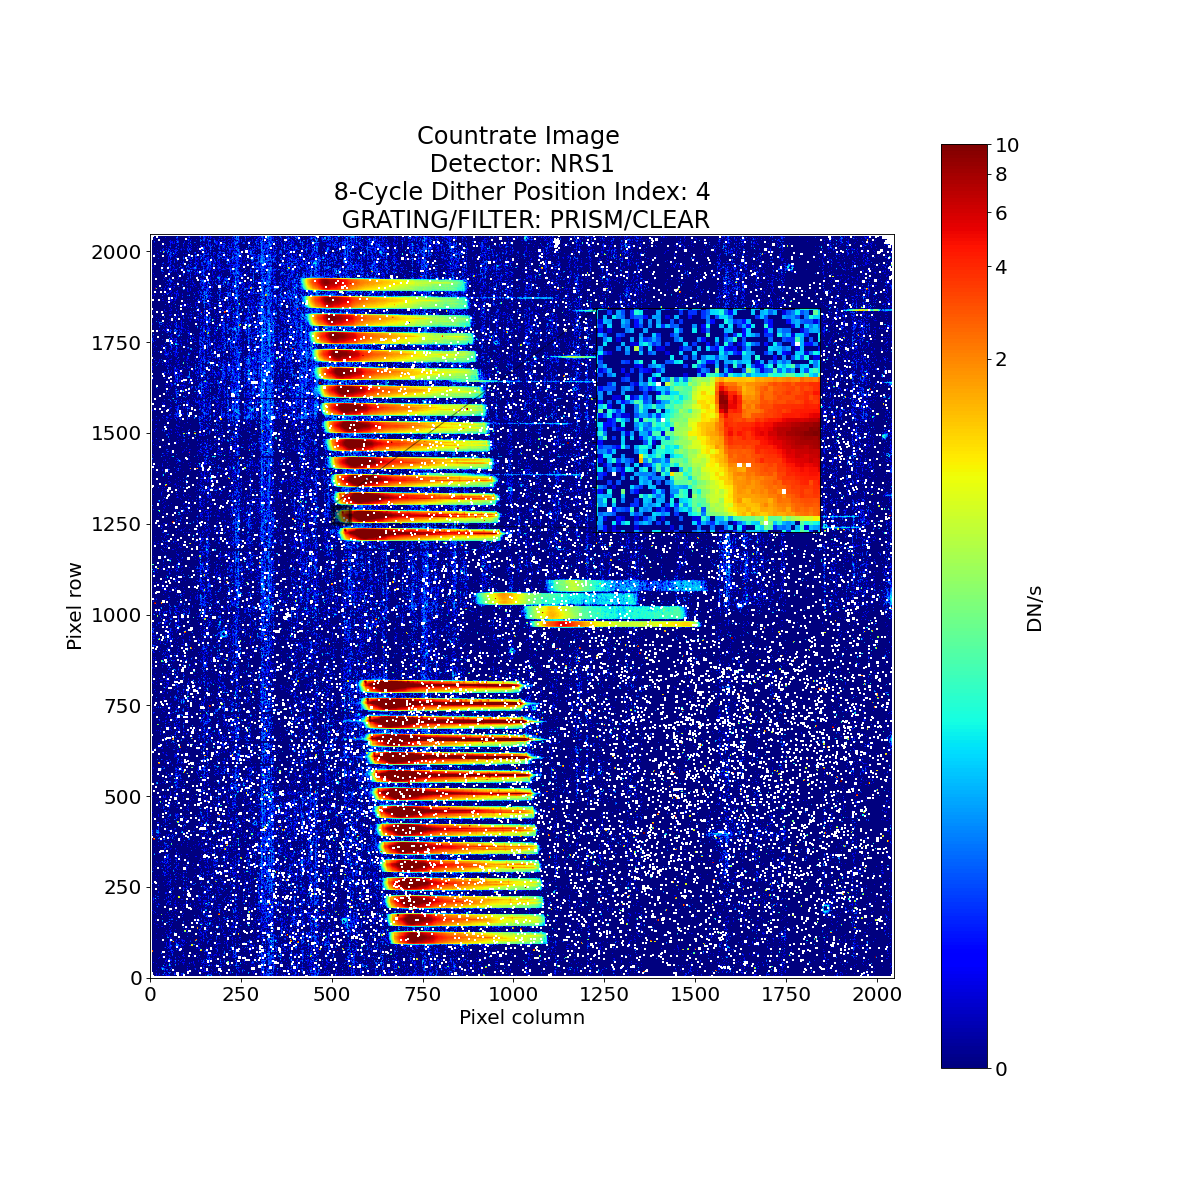

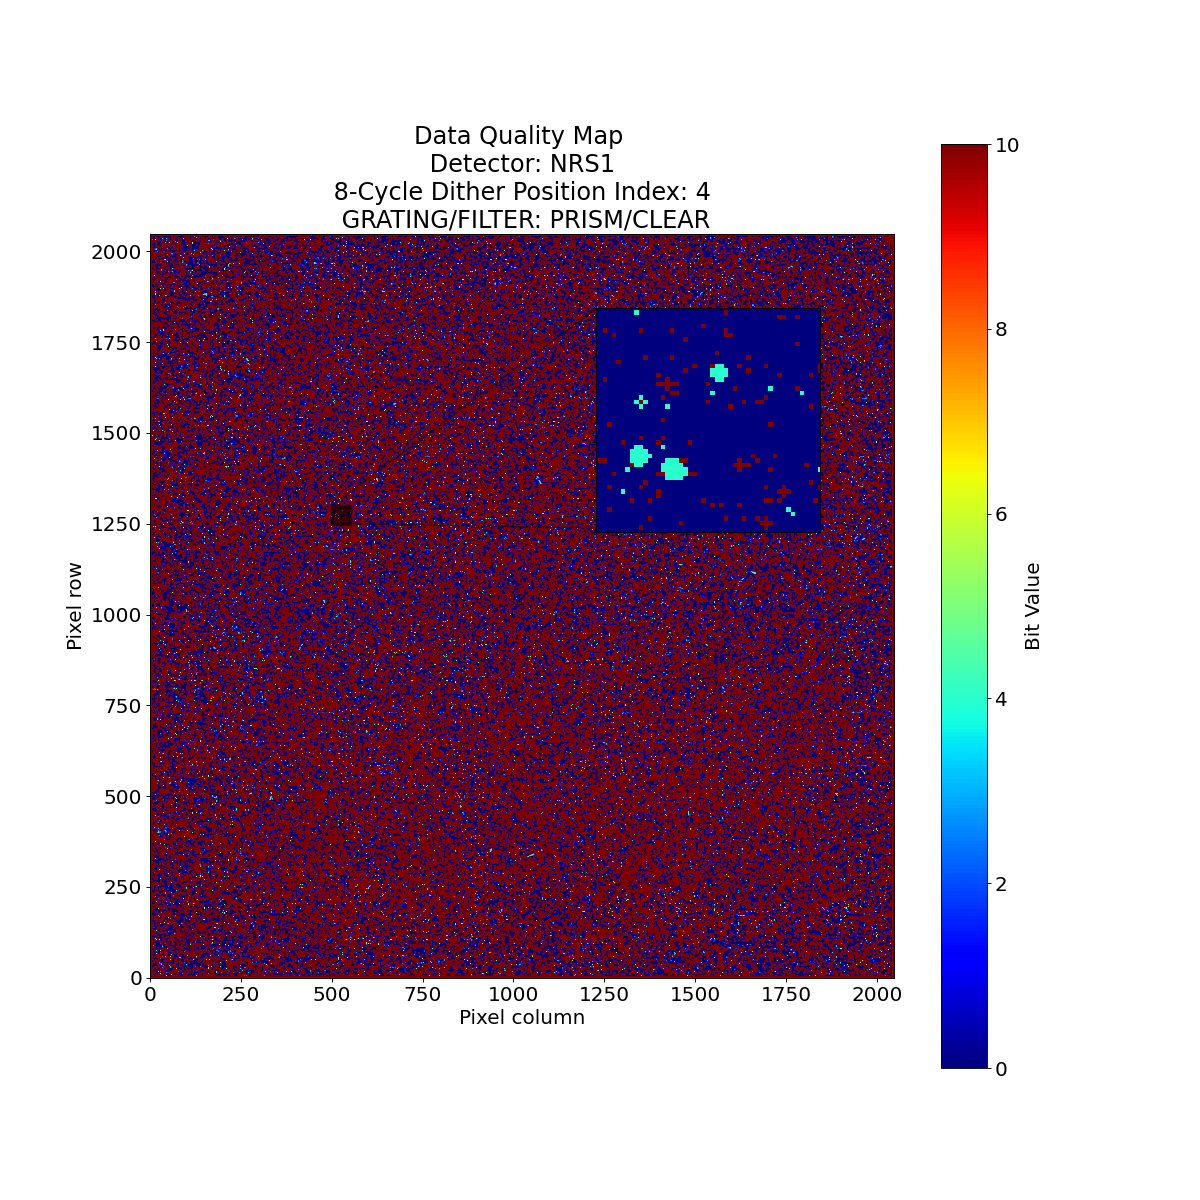

In [7]:
# Stage 1 slope products -- level 2a images

# Plot 4th (out of 8) dither position (NRS1 & NRS2) for GRATING/FILTER G140H/F100LP combination  
for rate_file in sorted(glob.glob(output_dir+'*00004_nrs?_rate.fits')):
    
    ratefile_open = datamodels.open(rate_file)
    ratefile_sci = ratefile_open.data # Get the pixel data (the SCI extension of the fits file)
    ratefile_dq = ratefile_open.dq # The Data Quality Map Data
    
    show_image(ratefile_sci, 0, 10, units='DN/s', zoom_in=[500, 550, 1250, 1300],
               title='Countrate Image \n Detector: {} \n 8-Cycle Dither Position Index: {} \n GRATING/FILTER: {}/{}'.format(ratefile_open.meta.instrument.detector,
                                                                                                                            ratefile_open.meta.dither.position_number, 
                                                                                                                            ratefile_open.meta.instrument.grating,
                                                                                                                            ratefile_open.meta.instrument.filter)) # rate files have units of DN/s
    show_image(ratefile_dq, 0, 10, units='Bit Value', scale='linear', zoom_in=[500, 550, 1250, 1300],
               title='Data Quality Map \n Detector: {} \n 8-Cycle Dither Position Index: {} \n GRATING/FILTER: {}/{}'.format(ratefile_open.meta.instrument.detector,
                                                                                                                             ratefile_open.meta.dither.position_number, 
                                                                                                                             ratefile_open.meta.instrument.grating,
                                                                                                                             ratefile_open.meta.instrument.filter)) # rate files have units of DN/s      

### 7. Stage 2  <a id='stage2'></a>
<hr style="border:1px solid gray">

This IFU data set focuses on an AGN target, which has a compact region at the center of its galaxy that can be considered a point source. To treat this IFU data as a point source, one must change the `SRCTYPE=POINT` header keyword in the `cal.fits` files before running stages 2 and 3 of the calibration pipeline. 

In [8]:
# Treating the IFU data as a point source 
# To run as a point source, alter the rate file header keywrod SRCTYAPT=POINT & rerun stage 2 of the pipeline 
# Loop through the copied rate files and update the source type keyword
for rate_file in sorted(glob.glob(output_dir+'*nrs1_rate.fits')):
    rate_file_hdu = fits.open(rate_file, 'update')
    
    # Change source type to point 
    rate_file_hdu[0].header['SRCTYAPT'] = 'POINT'
    
    rate_file_hdu.close()

During stage 2 of the pipeline, the countrate (slope) image products from stage 1, which have units of DN/s, are converted to units of surface brightness (MJy/sr) for both extended and point sources (as of DMS build 9.3/CAL_VER 1.10.2). For IFU point sources, the `extract_1d` step is controlled by a different set of parameters in the EXTRACT1D reference file: 

> For a point source, the spectrum is extracted using circular aperture photometry, **optionally (automatically) including background subtraction** using a circular annulus. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

When processing the IFU as a point source, the `extract_1d` step will automatically apply background subtraction unless otherwise told not to. The `extract_1d` step will also use the default circular extraction apertures for the source and background, an example of how to modify the EXTRACT1D reference file can be found at the end of this notebook.

<div class="alert alert-block alert-warning">
    
<b>Warning:</b> Note there has been a bug in the `cube_build` step that caused the point source flux to not be conserved when using different spatial sampling. A fix has been implemented as of release DMS build 9.3/CAL_VER 1.10.2. In order to enable the correct functionality, the units of the cal.fits files and cubes will now be in surface brightness, and only the 1-D extracted spectra will be in units of Jy.
</div>

In [9]:
# Stage 2 Processing 

if runflag:
    
    # Process each rate file separately 
    for rate_file in sorted(glob.glob(output_dir+'*nrs1*rate.fits')):
            
        print("Applying Stage 2 Calibrations & Corrections to: " + os.path.basename(rate_file))

        result = Spec2Pipeline.call(rate_file,
                                    save_results=True,
                                    output_dir=output_dir) 

Applying Stage 2 Calibrations & Corrections to: jw02732003001_02101_00001_nrs1_rate.fits


2023-10-06 14:37:46,107 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-10-06 14:37:46,121 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-10-06 14:37:46,122 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-10-06 14:37:46,123 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-10-06 14:37:46,123 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-10-06 14:37:46,124 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-10-06 14:37:46,125 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-10-06 14:37:46,127 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-10-06 14:37:46,128 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-10-06

KeyboardInterrupt: 

In [ ]:
# Stage 2 Products -- Calibrated 3-D data cube for PRISM/CLEAR (only falls on NRS1)

# Plotting the 4th (out of 8) dither position
stage2_s3d_file = sorted(glob.glob(output_dir+'*00004_nrs1_s3d.fits')) 

title_stage2_rerun = 'NGC 7319 AGN \n Level 2 IFU Product: 3-D Cube Slices vs. Corresponding 3-D Weighted Map'


# Characteristics of the plot 
nrs1_wavelengths = [1.4, 3.3, 4.5] # Wavelength slices (microns) to take from the 3-D data cube
nrs1_spaxel_locs = [[30, 29], [28, 39], [14, 25]] # Spaxel locations for associated 1-D spectrum (one spaxel plotted per slice)

# Plot using the convience function defined above
show_ifu_cubeslices(stage2_s3d_file, wavelength_slices=[nrs1_wavelengths], spaxel_locs=[nrs1_spaxel_locs], title=title_stage2_rerun)

### 8. Stage 3  <a id='stage3'></a>
<hr style="border:1px solid gray">

***Level 3 ASN File***

> Observations that use a nod-type/dither patterns, their exposures are related. [Association files (ASN)](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) describe how multiple exposures are related to one another and how they depend on one another. Processing an ASN file permits exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than individual objects. IFU exposures taken with a dither pattern are not used for pixel-to-pixel background subtraction by the calibration pipeline (unlike exposures taken with a nod pattern).

Therefore, all calibration files (`cal.fits`) in our spec3 ASN file should be labeled as science exposures (`exptype: science`).  

In [ ]:
# Copy ASN file from MAST into the stage 1 rerun directory

asnfile_mast = glob.glob(mast_products_dir+'*_spec3_00001_asn.json')[0] # ASN file found in MAST

asnfile_rerun_point = output_dir + os.path.basename(asnfile_mast) # New ASN file path
if not os.path.exists(asnfile_rerun_point):
    copy(asnfile_mast, asnfile_rerun_point)
    
# Check the ASN file contents
with open(asnfile_rerun_point, 'r') as f_obj:
    asnfile_rerun_point_data = json.load(f_obj)
        
asnfile_rerun_point_data

#### 8.1 New Outlier Detection Algorithm<a id='outlier_detection_new'></a>
<hr style="border:1px solid gray">

The new outlier detection algorithm for IFU data (as of DMS build B9.3rc1/CAL_VER 1.11.0) implements the basic outlier detection algorithm -- searches for pixels that are consistent outliers in the calibrated images created by the `calwebb_spec2` pipeline. The algorithm generally operates as follows:

> * Identifies outlier pixels by comparing them with their neighboring pixels in the spatial direction across a set of input files within an association.
> * For NIRSpec data, it calculates differences between pixels located above and below each science pixel.
> * The pixel differences for every input model in the association are computed and stored in a stack of pixel differences.
> * For each pixel, the algorithm determines the minimum difference across this stack and then performs normalization. This normalization process employs a local median derived from the difference array, with the size of the median determined by the kernel size.
> * A pixel is flagged as an outlier if this normalized minimum difference is greater than the input threshold percentage. 
> * Pixels that are found to be outliers are flaged in in the DQ array.
> * [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_ifu.html#outlier-detection-ifu)

**[The outlier_detection step for IFU data has the following optional arguments that control the behavior of the processing](https://github.com/spacetelescope/jwst/blob/master/docs/jwst/outlier_detection/arguments.rst):**

* `kernel_size` (string, default='7'): The size of the kernel to use to normalize the pixel differences. The kernel size must only contain odd values.
* `threshold_percent` (float, default=99.8): The threshold (in percent) of the normalized minimum pixel difference used to identify bad pixels. Pixels with a normalized minimum pixel difference above this percentage are flagged as a outlier.
* `save_intermediate_results` (boolean, default=False): Specifies whether or not to save any intermediate products created during step processing.


In [ ]:
# Rerun stage 3 with outlier detection on
if runflag:
    result = Spec3Pipeline.call(asnfile_rerun_point,
                                save_results=True,
                                output_dir=output_dir,
                                steps={"outlier_detection": {"skip": False,
                                                             "save_results": True,
                                                             "kernel_size": '3 3'},
                                       "extract_1d": {"subtract_background": False}}) # Do not automatically apply background subtraction until we modify the extraction region

In [ ]:
# Stage 3 Products -- Combined Calibrated 3-D data cube for PRISM/CLEAR 

stage3_s3d_file_point = sorted(glob.glob(output_dir+'*nirspec_prism-clear_s3d.fits')) 

title_stage3_rerun_point = 'NGC 7319 AGN \n Level 3 IFU Product: 3-D Cube Slices vs. Corresponding 3-D Weighted Map'

# Characteristics of the plot 
nrs1_wavelengths = [1.4, 3.3, 4.5] # Wavelength slices (microns) to take from the 3-D data cube
nrs1_spaxel_locs = [[30, 29], [28, 39], [14, 25]] # Spaxel locations for associated 1-D spectrum (one spaxel plotted per slice)
vmin_vmax_point = [[0, 150], [0, 150], [0, 150]]

# Plot using the convience function defined above
show_ifu_cubeslices(stage3_s3d_file_point, wavelength_slices=[nrs1_wavelengths], spaxel_locs=[nrs1_spaxel_locs], vmin_vmax=[vmin_vmax_point], title=title_stage3_rerun_point)

In [ ]:
# Stage 3 Products -- Extracted 1-D Spectrum 

# Combined 1-D extracted spectrum
x1d3_rerun_point = datamodels.open(glob.glob(output_dir+'*nirspec_prism-clear_x1d.fits')[0])

# Wavelength & Surface Brightness Arrays
x1d3wave_rerun_point = x1d3_rerun_point.spec[0].spec_table.WAVELENGTH
x1d3flux_rerun_point = x1d3_rerun_point.spec[0].spec_table.FLUX

# Plot the Extracted 1-D Spectrum
fig = plt.figure(figsize=(15, 9))

plt.plot(x1d3wave_rerun_point, x1d3flux_rerun_point, linewidth=2)

# Where wavelength slice was taken above
plt.vlines(1.4, 0., 400., 'black', 'dotted', label='1.4 microns')
plt.vlines(3.3, 0., 400., 'red', 'dotted', label='3.3 microns')
plt.vlines(4.5, 0., 400., 'green', 'dotted', label='4.5 microns')

plt.xlabel(r'$\lambda [\mu$m]', fontsize=20)
plt.ylabel('Flux (Jy)', fontsize=20)
plt.title("NGC 7319 AGN \n Level 3 IFU Product in MAST: Extracted 1-D Spectrum", fontsize=20)
plt.ylim(0, 10**-1.6)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, -2))
plt.legend()
plt.show()

#### 8.2 Extract 1-D Step: Modified Reference File<a id='extract_1d'></a>
<hr style="border:1px solid gray">  

As a point source, the `extract_1d` step is controlled by a different set of parameters in the EXTRACT1D reference file:

>[Extraction for 3-D IFU Data:](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)
>
> For point source data the extraction aperture is centered at the RA/DEC target location indicated by the header. If the target location is undefined in the header, then the extraction region is the center of the IFU cube.
>
>For point sources a circular extraction aperture is used, along with an optional circular annulus for background extraction and subtraction. The size of the extraction region and the background annulus size varies with wavelength. The extraction related vectors are found in the asdf EXTRACT1D reference file. For each element in the wavelength vector there are three size components: `radius`, `inner_bkg`, and `outer_bkg`. The radius vector sets the extraction size; while `inner_bkg` and `outer_bkg` specify the limits of an annular background aperture. 

Here, we show how to modify the EXTRACT1D reference file to obtain better results. 

<div class="alert alert-block alert-warning">
    
<b>Warning:</b> The default extraction aperture radius has been set to match what was used to derive the flux calibration. If you want to use a different aperture size, you will need to compute and apply a custom aperture correction to ensure the correct flux, as we have not yet updated the aperture correction reference files.
</div>

In [ ]:
# Extraction Region Preview
# Open Combined 3-D Cube FITS file
s3d = fits.open(glob.glob(output_dir+'*nirspec_prism-clear_s3d.fits')[0])
cube = s3d[1].data  # Science data

# Plot the full IFU cube
ax = plt.subplot(1, 1, 1)  # , projection=wcs, slices=('x', 'y', nslice3)) # Set up the subplot space
slice_mean = np.nanmean(cube[400:500, :, :], axis=0) # Mean of the slice looking in the range (nslice2-2):(nslice2+2)
slice_norm = ImageNormalize(slice_mean, vmin=0, vmax=150, stretch=AsinhStretch()) # Normalize &stretch
slice_full = ax.imshow(slice_mean, norm=slice_norm, origin='lower', cmap='jet') # Plot slice

# Colorbar
cb_image = plt.colorbar(slice_full, fraction=0.046, pad=0.04)
cb_image.set_label('MJy/sr', labelpad=-1, fontsize=10)
cb_image.ax.tick_params(labelsize=10)
cb_image.ax.yaxis.get_offset_text().set_fontsize(10)

radius = Circle((29, 29), 9, fill=False, label='Radius')
inner_bkg = Circle((29, 29), 10, color='b', fill=False, label='Inner Background Radius')
outer_bkg = Circle((29, 29), 15, color='r', fill=False, label='Outer Background Radius')
ax.add_patch(radius)
ax.add_patch(inner_bkg)
ax.add_patch(outer_bkg)
ax.legend(fontsize=10)
ax.set_xlabel('X (pixels)', fontsize=10)
ax.set_ylabel('Y (pixels)', fontsize=10)
ax.grid(color='white', ls='solid')
ax.set_title('Full IFU Cube: \n Extraction Region Preview', fontsize=15)

In [ ]:
# Grab the default extract1d reference file and copy to working directory
extract1d_ref_og = Spec3Pipeline().get_reference_file(glob.glob(output_dir+'*nirspec_prism-clear_s3d.fits')[0], 'extract1d')
if not os.path.exists(output_dir+os.path.basename(extract1d_ref_og)):
    copy(extract1d_ref_og, output_dir+os.path.basename(extract1d_ref_og))

if runflag:
    # Make Changes to the ASDF file and Write to a new file
    with asdf.open(output_dir+os.path.basename(extract1d_ref_og), mode='rw') as ff:
        ff.tree['data']['radius'] = np.full((2048,), 9, dtype='float32')
        ff.tree['data']['inner_bkg'] = np.full((2048,), 10, dtype='float32')
        ff.tree['data']['outer_bkg'] = np.full((2048,), 15, dtype='float32')
        ff.write_to(output_dir+'new_extract1d_reference_file.asdf')

In [ ]:
# Rerun only the extract1d step with the new/modified reference file with background subtraction on

if runflag:
    Extract1dStep.call(glob.glob(output_dir+'*nirspec_prism-clear_s3d.fits')[0], 
                       save_results=True,
                       output_dir=output_dir, 
                       override_extract1d=output_dir+'new_extract1d_reference_file.asdf')

In [ ]:
# Display new 1-D spectrum

# Combined 1D extracted spectrum
x1d3 = datamodels.open(glob.glob(output_dir+'*nirspec_prism-clear_extract1dstep.fits')[0])

# Wavelength & Surface Brightness Arrays
x1d3wave = x1d3.spec[0].spec_table.WAVELENGTH
x1d3flux = x1d3.spec[0].spec_table.FLUX

# Plot the Extracted 1D Spectrum
fig = plt.figure(figsize=(15, 9))

plt.plot(x1d3wave, x1d3flux, linewidth=2)

# Where wavelength slice was taken above
plt.vlines(1.4, 0., 400., 'black', 'dotted', label='1.4 microns')
plt.vlines(3.3, 0., 400., 'red', 'dotted', label='3.3 microns')
plt.vlines(4.5, 0., 400., 'green', 'dotted', label='4.5 microns')

plt.xlabel(r'$\lambda [\mu$m]')
plt.ylabel('Flux (Jy)', fontsize=20)
plt.title("NGC 7319 AGN \n Level 3 IFU Product: Extracted 1-D Spectrum with Background Subtraction")
plt.ylim(0, 10**-1.6)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, -2))
plt.legend()
plt.show()

## About This Notebook <a id='about'></a>
<hr style="border:1px solid gray">  

**Authors**: Kayli Glidic (kglidic@stsci.edu), Leonardo Ubeda (lubeda@stsci.edu)

**Update On**: 2023-08-11